# Spring returns to the Great Plains

Mapping Tasiyagnunpa migration

## Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace.

In [1]:
%store -r

# Import libraries

## STEP 4: Count the number of observations in each ecosystem, during each month of 2023

Much of the data in GBIF is **crowd-sourced**. As a result, we need not
just the number of observations in each ecosystem each month – we need
to **normalize** by some measure of **sampling effort**. After all, we
wouldn’t expect the same number of observations at the North Pole as we
would in a National Park, even if there were the same number organisms.
In this case, we’re normalizing using the average number of observations
for each ecosystem and each month. This should help control for the
number of active observers in each location and time of year.

### Set up your analysis

First things first – let’s load your stored variables.

In [2]:
%store -r ecoregions_gdf gbif_gdf

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</li>
<li>Select only the columns you will need for your plot.</li>
<li>Run the code.</li>
</ol></div></div>

In [3]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='right', 
        predicate='intersects')
    # Select the required columns
    [['ecoregion' , 'SHAPE_AREA' , 'month']]
)
gbif_ecoregion_gdf

,ecoregion,SHAPE_AREA,month
gbifID,,,
4501319588,790.0,49.311356,5
4501319649,790.0,49.311356,7
4697139297,162.0,46.807295,2
4735897257,790.0,49.311356,4
4719794206,790.0,49.311356,6
...,...,...,...
4796460466,87.0,4.727694,4
4720342585,172.0,28.732790,4
4725888708,513.0,86.168963,6


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [4]:
occurrence_df = (
    gbif_ecoregion_gdf
    # For each ecoregion, for each month...
    .groupby(['month' , 'ecoregion'])
    # ...count the number of occurrences
   .agg(
       occurrences=('SHAPE_AREA', 'count'),
   area=('SHAPE_AREA' , 'first'))


)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>=1]

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
   occurrence_df
   .groupby('ecoregion')
   .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
   .groupby('month')
   .mean()
)

display(mean_occurrences_by_ecoregion)

mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

,occurrences,area
ecoregion,,
12.0,12.428571,17.133639
32.0,1.000000,16.637804
33.0,2.000000,18.674884
42.0,1.000000,29.269387
43.0,96.416667,10.853227
...,...,...
793.0,386.333333,1.695309
796.0,225.250000,14.520123
821.0,1.000000,9.664680


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [5]:
# normalize by spatial area
occurrence_df['occurrences_norm_area'] = (
    occurrence_df.occurrences / occurrence_df.area)
occurrence_df

occurrences       area  occurrences_norm_area
month ecoregion                                               
1     33.0                 3  18.674884               0.160644
      43.0                62  10.853227               5.712587
      59.0                49   7.110701               6.891023
      73.0                21   8.066966               2.603209
      87.0              2147   4.727694             454.132623
...                      ...        ...                    ...
12    790.0             1910  49.311356              38.733471
      793.0              422   1.695309             248.922141
      796.0                1  14.520123               0.068870
      821.0                1   9.664680               0.103470
      833.0                5  35.905513               0.139254

[739 rows x 3 columns]

<Axes: ylabel='Frequency'>

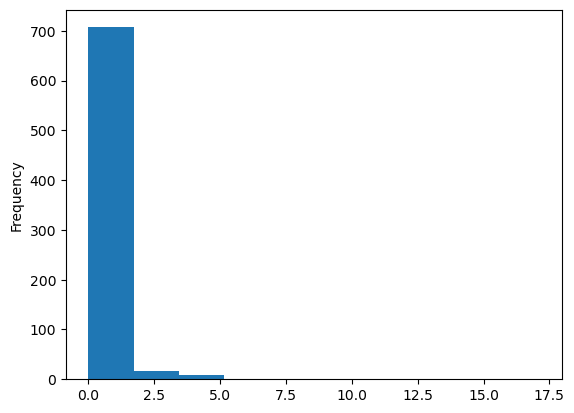

In [6]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (

    occurrence_df.occurrences_norm_area
    / mean_occurrences_by_ecoregion.occurrences
)
occurrence_df.norm_occurrences.plot.hist()

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="015f18c7" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

## Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! This code will store all your variables. You might want to
specify specific variables, especially if you have large objects in
memory that you won’t need in the future.

In [7]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!